<a href="https://colab.research.google.com/github/Jeremy26/neural_optimization_course/blob/main/knowledge_distillation_cityscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Knowledge Distillation Workshop!

In this workshop, we'll learn the concept of Model Optimization using Knowledge Distillation using Pytorch.

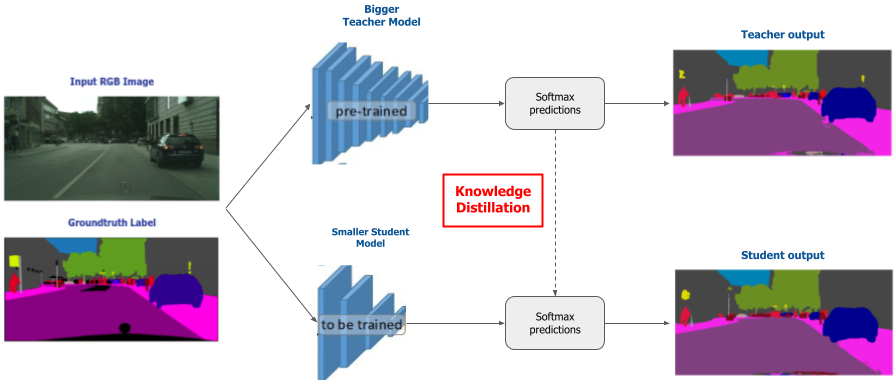

We'll do the following tasks:
1. Dataset exploration mainly w.r.t to `KD for Semantic Segmentation`  and associated `metrics`
2. Load a *Pretrained Teacher* model and calculate `meanIoU metric` and inference metrics
3. Plain Student Model Architecture, Performance and inference metrics
4. Train a `Student model using KL-divergence + Cross entropy loss` function
5. Performance comparison between Teacher and Student models

## Imports

In [1]:
!wget https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/kd_content.zip && unzip -q kd_content.zip && rm kd_content.zip 

--2022-01-26 14:16:49--  https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/kd_content.zip
Resolving optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)... 52.95.156.52
Connecting to optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)|52.95.156.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2737833676 (2.5G) [application/zip]
Saving to: ‘kd_content.zip’

kd_content.zip      100%[===================>]   2.55G  32.5MB/s    in 81s     

2022-01-26 14:18:11 (32.0 MB/s) - ‘kd_content.zip’ saved [2737833676/2737833676]



In [2]:
# Basic imports
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# DL imports 
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# MAKE RESULTS REPRODUCIBLE
from scripts.helper import set_seed
set_seed(1)

In most approaches, ***student layer distributions are matched with teacher layer distributions using techniques like Kullback-Leibler Divergence minimisation***, which we'll see in later sections

## 1. Dataset exploration w.r.t `KD for Semantic Segmentation` and metrics

- As explained earlier, during training the student model learns from the teacher model predictions
- Hence, we'll need a ***Dataset which can provide the Teacher predictions along with RGB image and GroundTruth labels***


There are two ways we can achieve that.
1. We'll use the normal setup where the Dataset returns just the RGB image and the groundtruth label. ***Teacher predictions can be got by passing the RGB image to the model during training loop***. This method is ***slower*** because we need to do a forward pass on the huge teacher model for every input image. But the setup is ***simpler***

2. Alternative is to ***store the teacher predictions and load them directly from file / cache***. This method is ***faster*** as we directly load teacher predictions, but ***requires more space and separate Dataset***

*We'll use the 2nd method to illustrate how to setup a Pytorch Dataloader for Knowledge Distillation*


NOTE: 
- One crucial aspect when using cached Predictions is that the ***input image passed to the teacher and student models, including augumentations must be exact same***
- This might require us to store the augumented dataset which might increase disk space requirements 
- ***We need teacher predictions only during training and not during inference***


In [3]:
class cityScapeDataset_KD(Dataset):
    def __init__(self, rootDir:str, folder:str, tf=None):
        self.rootDir = rootDir
        self.folder = folder
        self.transform = tf

        # reference folders for reading images
        sourceImgFolder =  os.path.join(self.rootDir, 'leftImg8bit', self.folder)
        labelImgFolder =  os.path.join(self.rootDir, 'gtFine', self.folder)
        teacherPredsFolder =  os.path.join(self.rootDir, 'teacherPreds', self.folder)

        ### SINCE WE HAVE LIMITED SPACE, WE'RE USING ONLY THE COMMON FILES
        ### FOR DATASET CONSIDERATION WHERE TEACHER PREDICTIONS ARE ALSO AVAILABLE.
        ### IF YOU HAVE ENOUGH DISK SPACE, YOU CAN REMOVE THIS SECTION OF CODE
        
        teacherPredsFiles = os.listdir(teacherPredsFolder)
        sourceImgFiles = os.listdir(sourceImgFolder)
        labelImgFiles = os.listdir(labelImgFolder)
        
        teacherPredsFilesBaseName = set([os.path.basename(x).split('.')[0] for x in teacherPredsFiles])
        sourceImgFilesBaseName = set([os.path.basename(x).split('.')[0] for x in sourceImgFiles])
        labelImgFilesBaseName = set([os.path.basename(x).split('.')[0] for x in labelImgFiles])
        commonFiles = sorted(list(teacherPredsFilesBaseName.intersection(sourceImgFilesBaseName).intersection(labelImgFilesBaseName)))
        
        ### END OF ADDITIONAL SECTION FOR SIZE CONSIDERATION ###

        # source image list
        self.sourceImgFiles  = [os.path.join(sourceImgFolder, f'{x}.png') for x in commonFiles]

        #  label image list
        self.labelImgFiles  = [os.path.join(labelImgFolder, f'{x}.png') for x in commonFiles]

        # teacher predictions file list
        self.teacherPredsFiles  = [os.path.join(teacherPredsFolder, f'{x}.pt') for x in commonFiles]
        
    def __len__(self):
        return len(self.sourceImgFiles)
  
    def __getitem__(self, index):
        # read source image and convert to RGB, apply transform
        sourceImage = cv2.imread(f"{self.sourceImgFiles[index]}", -1)
        sourceImage = cv2.cvtColor(sourceImage, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            sourceImage = self.transform(sourceImage)

        # read label image and convert to torch tensor
        labelImage  = torch.from_numpy(cv2.imread(f"{self.labelImgFiles[index]}", -1)).long()
        
        # read teacher predictions from file and return torch tensor
        teacherPreds = torch.load(self.teacherPredsFiles[index], map_location=torch.device('cpu')).squeeze(0)
        return sourceImage, labelImage, teacherPreds

We'll split the training data into train and validation sets and create Dataloaders for each

In [4]:
NUM_CLASSES = 19
IGNORE_INDEX = 255

# Convert to torch tensor and normalize images using Imagenet values
tf = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

trainData = cityScapeDataset_KD(rootDir='semSeg_256_512', folder='train', tf=tf)


# split the train data into train and validation sets
VAL_SET_SIZE = 0.2   # percentage of data for validation
totalNumTrainSamples = len(trainData)
trainSet, valSet = torch.utils.data.random_split(trainData, [round(totalNumTrainSamples * (1-VAL_SET_SIZE)), 
                            round(totalNumTrainSamples * VAL_SET_SIZE)],
                             generator=torch.Generator().manual_seed(1))

# batch size for data loaders
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE  = 8

# Pytorch loaders for training and validation 
trainDataloader = DataLoader(trainSet, batch_size=TRAIN_BATCH_SIZE)
valDataloader   = DataLoader(valSet, batch_size=TEST_BATCH_SIZE)

# CUSTOM TORCH DATASET TO LOAD DATA
from scripts.helper import cityScapeDataset

# test dataset and dataloaders setup
testSet = cityScapeDataset(rootDir='semSeg_256_512', folder='val', tf =tf)
testSet = torch.utils.data.Subset(testSet, indices=np.arange(100))
testDataloader  = DataLoader(testSet, batch_size=TEST_BATCH_SIZE)

Let's verify size of images from the dataset

In [5]:
rgb_image, label_image, teacherPreds = trainSet[0]
print(f"There are {len(trainSet)} train images, {len(valSet)} validation images, {len(testSet)} test Images")
print(f"Input shape = {rgb_image.shape}, output label shape = {label_image.shape}, teacherPreds shape = {teacherPreds.shape}")

There are 120 train images, 30 validation images, 100 test Images
Input shape = torch.Size([3, 256, 512]), output label shape = torch.Size([256, 512]), teacherPreds shape = torch.Size([19, 256, 512])


NOTE : teacherPreds shape = (NUM_CLASSES, OUTPUT_HEIGHT, OUTPUT_WIDTH) and it contains softmax predictions for the 19 classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


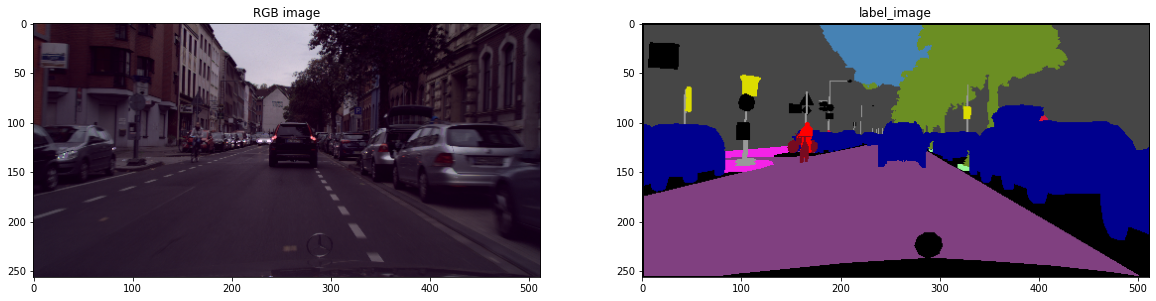

In [6]:
# when using torch dataset we defined earlier, the output image
# is normalized. So we're defining an inverse transformation to 
# transform to normal RGB format
from scripts.helper import inverse_transform, decodeTarget        
        
source_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
colormapped_label_image = decodeTarget(label_image).astype('uint8')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 40))
ax1.imshow(source_image)
ax1.set_title("RGB image")
ax2.imshow(colormapped_label_image)
ax2.set_title("label_image")
plt.show()

### *Metric for Semantic Segmentation*

We'll use the same `meanIoU` metric definition used in the Quantization worksop

In [7]:
from scripts.helper import meanIoU

## 2. Load a Pretrained Teacher model and calculate meanIoU metric and inference metrics

*deeplabv3_resnet50 Training Procedure description*
- Trained for 12 epochs on trainSet with batchsize of 8
- nn.CrossEntropyLoss(ignore_index=255)
- lr_scheduler = OneCycleLR(max_lr=1e-3, pct_start=0.3, div_factor=10, anneal_strategy='cos')
- meanIoU is used as metric function
- The model with the minimum validation loss is saved


***Teacher model is the deeplabv3_resnet50 model used previously***

In [8]:
# import model class
from scripts.models.segmentation import deeplabv3_resnet50

# device definition
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

# load pretrained model and transfer to CPU, set to inference mode
teacher_model = deeplabv3_resnet50(pretrained=False, num_classes=NUM_CLASSES)
teacher_model.load_state_dict(torch.load('weightFiles/deeplabv3_r50.pt', map_location=gpu_device))
teacher_model.eval();

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

We'll use the same `evaluateOnTestData` function from the Quantization workshop to find metric on test data

In [9]:
# evaluate performance on Test set
from scripts.helper import evaluteOnTestData
teacher_model_metric = evaluteOnTestData(teacher_model, None, gpu_device, testDataloader, meanIoU, 
                                    'meanIoU', 'teacher_model_deepLabv3')
print(f"\nteacher_model has {round(teacher_model_metric,3)} IoU metric on test data")

100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


teacher_model has 0.597 IoU metric on test data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


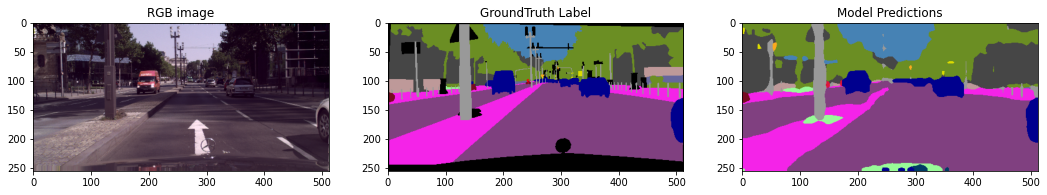

In [10]:
from scripts.helper import visualizePredictions
visualizePredictions(teacher_model, testSet, gpu_device, 1)

In [11]:
# UTILITY FUNCTION TO CALCULATE INFERENCE METRICS FOR MODELS
from scripts.modelMetrics import modelMetrics

torch.set_num_threads(1)
_ = modelMetrics(teacher_model, modelName= 'teacher_model_deeplabv3', 
             input=torch.rand(1,3,256,256), device=cpu_device, verbose=True)

-------------
 Metrics of teacher_model_deeplabv3 
-------------


/content/scripts/pytorch-OpCounter-master/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor([*(y.shape[2:])])


Device = cpu
40965.789184 MMACs, 81931.578368 MFLOPs and 39.638355 M parameters
Model FileSize = 158.937101 MB
Single batch inference Time of model = 1312.717890739441 milliseconds


***Results***

Teacher model of the pretrained deeplabv3_resnet50 
- Has ***0.59 mean IoU*** metric on Test set
- Takes ***1450 ms*** inference time on CPU

## 3. Plain Student Model Architecture, Performance and inference metrics

The Student model in our case is a [PSPNet model](https://arxiv.org/pdf/1612.01105.pdf) with a resnet50 backbone. PSPNet architecture is as follows:

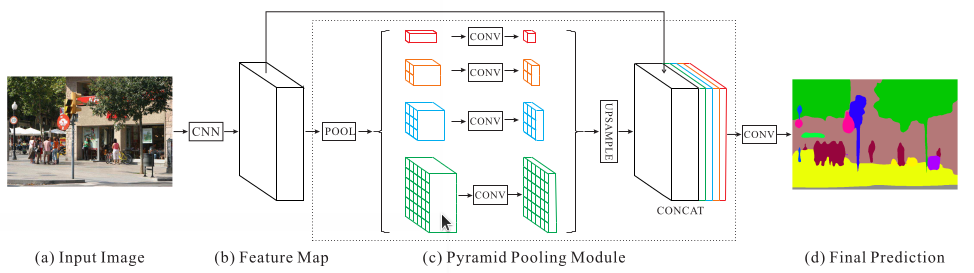

*Reference* : 
1. [PSPNet blog post](https://developers.arcgis.com/python/guide/how-pspnet-works/)
2. [Comparison of Semantic Segmentation](https://arxiv.org/pdf/1905.10231.pdf)

Specifically, we'll use the same `resnet50 backbone` as in the teacher model. [reference model implementation](https://github.com/yassouali/pytorch-segmentation). We'll load a `pretrained PSPNet model (referred to as plain_student_model hereafter) which was trained without supervision` and evaluate its performance on the test set and inference metrics

*PSPNet_resnet50 Training Procedure description*
- Trained for 12 epochs on trainSet with batchsize of 8
- nn.CrossEntropyLoss(ignore_index=255)
- lr_scheduler = OneCycleLR(max_lr=1e-3, pct_start=0.3, div_factor=10, anneal_strategy='cos')
- meanIoU is used as metric function
- The model with the minimum validation loss is saved

  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 13/13 [00:05<00:00,  2.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



plain_student_model has 0.316 IoU metric on test data


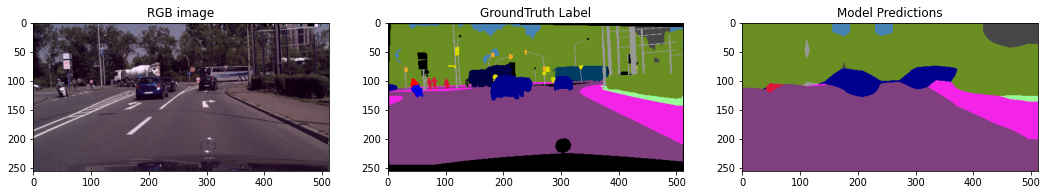

In [12]:
from scripts.models.pspnet import PSPNet

# load pretrained model, transfer to target Device and set to inference mode
plain_student_model = PSPNet(num_classes=NUM_CLASSES, backbone='resnet50', pretrained=False, use_aux=False).to(gpu_device)
plain_student_model.eval();
plain_student_model.load_state_dict(torch.load('weightFiles/plain_pspnet.pt', map_location=gpu_device))


# evaluate performance on Test set
plain_student_model_metric = evaluteOnTestData(plain_student_model, None, gpu_device, testDataloader, meanIoU, 
                                    'meanIoU', 'plain_student_model_pspnet')
print(f"\nplain_student_model has {round(plain_student_model_metric,3)} IoU metric on test data")

# Visualize output predictions
visualizePredictions(plain_student_model, testSet, gpu_device, 1)

In [13]:
# inference metrics of plain_student model
_ = modelMetrics(plain_student_model, modelName= 'plain_student_model_pspnet', 
             input=torch.rand(1,3,256,256), device=cpu_device, verbose=True)

-------------
 Metrics of plain_student_model_pspnet 
-------------


/content/scripts/pytorch-OpCounter-master/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor([*(y.shape[2:])])
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Device = cpu
6628.97376 MMACs, 13257.94752 MFLOPs and 46.591571 M parameters
Model FileSize = 205.645861 MB
Single batch inference Time of model = 280.1344394683838 milliseconds


***Results***

Plain student model of the pretrained PSPNet_resnet50 
- Has ***0.32 mean IoU*** metric on Test set
- Takes ***~300 ms*** inference time on CPU

*WE HAVE A PLAIN STUDENT MODEL WHICH IS ~5 TIMES FASTER THAN TEACHER MODEL AND HAS 0.32 MEAN_IOU. OUR GOAL IS TO IMPROVE THE IOU_METRIC USING KNOWLEDGE DISTILLATION FROM THE TEACHER MODEL*

## 4. Train a Student model using KL-divergence + Cross entropy loss functions

- To distill knowledge from the teacher to the student, we need to take into account the predictions of the Teacher model when calculating the loss for the student model. One way of doing so is to use the *Kullback-Leibler Divergence* loss function.
- **KLD is a metric to quantify how different a distribution is w.r.t to another distribution**. In our case, it can be used to measure how different student model predictions is from the teacher model prediction.
- During student model training, we add the KL-Divergence loss between the teacher and student model predictions along with the primary loss function (Cross-entropy in this case)

General form of Knowledge Distillation loss is as follows: 

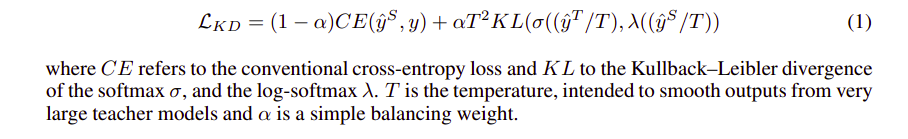

In [14]:
import torch.nn.functional as F

def KLDLoss(studentPreds, teacherPreds, T=1.0):
    """ Compute the knowledge-distillation (KD) loss given teacher and student predictions """
    x = F.log_softmax(studentPreds/T, dim=1)
    y = F.softmax(teacherPreds/T, dim=1)
    KDLoss = F.kl_div(x,y, reduction='batchmean')
    return KDLoss


def kdLossFunction(targetLabels, studentPreds, teacherPreds, criterion, T=1.0, alpha=0.7):
    studentClassificationLoss = criterion(studentPreds, targetLabels) 
    distillationLoss = KLDLoss(studentPreds, teacherPreds, T)
    kdLoss = (1.0 - alpha) * studentClassificationLoss + (alpha * T * T) * distillationLoss
    return kdLoss

*NOTE*
- `alpha` and `Temperature` are hyperparameters in knowledge distillation
- *alpha* value ranges between 0 to 1 where higher values indicate more weightage given to KLD loss compared to loss on groundtruth
- *Temperature* is a softening parameter used to moderate the amount of information from the teacher model. 
- Detailed information on empricial values for alpha and temperature can be found in the [original Knowledge distillation paper](https://arxiv.org/abs/1503.02531)

We'll define the training loop with some modifications for knowledge distillations

In [15]:
import pandas as pd
from scripts.modelUtils import plotTrainingResults


def train_validateModel_KD(studentModel, criterion, distillationLossFn,
                        optimizer, dataloader_train, dataloader_valid, metricFunction, 
                        metricName, device, modelName, lr_scheduler, 
                        saveModel=False, verbose=False, plotResults=False):
    """Function runs train and validation cycles of the Student model 
    on given dataset using teacher model and inputs. The teacher model is 
    assumed to have been loaded with pretrained weights and only the student 
    model is trained. Parameters `T` and `ALPHA` required for knowledge distillation
    """    
    print("------------------------")
    print(f"Train Validate Pipeline for - {modelName} on {str(device)}")
    print("------------------------")
    results = []    
    minValidationLoss = np.Inf
    lenTrainLoader = len(dataloader_train)
    
    # move student model to target device
    studentModel.to(device)

    print("------------------------")
    print(f"KD parameters = - alpha = {alpha}, temperature = {temperature}")
    print("------------------------")

    for epoch in range(N_EPOCHS):
        if verbose == True:
            print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        studentModel.train()
        trainLoss = 0.0
        for i, (inputs, labels, teacherModelPreds) in tqdm(enumerate(dataloader_train), total=lenTrainLoader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            teacherModelPreds = teacherModelPreds.to(device)

            # Forward pass on teacher and student model
            studentModelPreds = studentModel(inputs)

            # total loss = hard target loss fn + distillation loss using teacher predictions
            loss = distillationLossFn(labels, studentModelPreds, teacherModelPreds, 
                                        criterion, temperature, alpha)
            trainLoss += loss.item()
                    
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            
            # adjust learning rate
            lr_scheduler.step()

        
        # Validate
        studentModel.eval()
        validationLoss = 0.0
        metricObject = metricFunction(device)

        with torch.no_grad():
          for inputs, labels, _ in dataloader_valid:
            inputs = inputs.to(device)
            labels = labels.to(device)  
            y_preds = studentModel(inputs)
            
            # calculate loss
            loss = criterion(y_preds, labels)
            validationLoss += loss.item()
                
            # update batch metric information            
            metricObject.update(y_preds.cpu().detach(), labels.cpu().detach())

        # compute per batch losses
        trainLoss = trainLoss / len(dataloader_train)
        validationLoss = validationLoss / len(dataloader_valid)

        # compute metric
        validationMetric = metricObject.compute()

        if verbose == True:
            print(f'Epoch: {epoch+1}, trainLoss:{trainLoss:6.5f}, validationLoss:{validationLoss:6.5f}, {metricName}:{validationMetric: 4.2f}%')
        
        # store results
        results.append({'epoch': epoch, 'trainLoss': trainLoss, 
                        'validationLoss': validationLoss, f'{metricName}': validationMetric})
        
        # if validation loss has decreased and user wants to
        if validationLoss <= minValidationLoss:
            minValidationLoss = validationLoss
            if saveModel == True:
                torch.save(studentModel.state_dict(), f'{modelName}.pt')


    if plotResults ==True:
        results = pd.DataFrame(results)
        plotTrainingResults(results, f'{modelName}')                
    return results

We'll use the same hyperparameters used for training the plain student model.


------------------------
Train Validate Pipeline for - temp_KD_student on cuda
------------------------
------------------------
KD parameters = - alpha = 0.7, temperature = 1.0
------------------------
Starting 1 epoch ...


  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 15/15 [00:10<00:00,  1.40it/s]
/content/scripts/helper.py:399: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


Epoch: 1, trainLoss:133206.14688, validationLoss:3.06065, meanIoU: 0.06%
Starting 2 epoch ...


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


Epoch: 2, trainLoss:77093.01380, validationLoss:1.94849, meanIoU: 0.07%
Starting 3 epoch ...


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


Epoch: 3, trainLoss:63182.00703, validationLoss:0.87689, meanIoU: 0.16%
Starting 4 epoch ...


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


Epoch: 4, trainLoss:53546.83542, validationLoss:0.78643, meanIoU: 0.18%


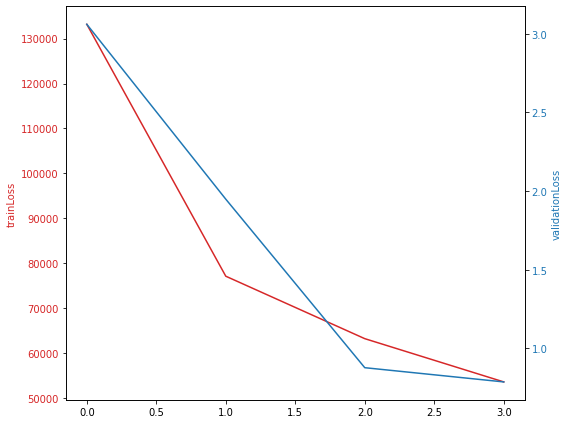

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# training hyperparameters
N_EPOCHS = 4
MAX_LR = 1e-3
criterion = nn.CrossEntropyLoss(ignore_index = IGNORE_INDEX)

# knowledge distillation hyperparameters
alpha = 0.7
temperature = 1.0

# create model, optimizer, lr_scheduler and pass to training function
kd_student_model = PSPNet(num_classes=NUM_CLASSES, backbone='resnet50', pretrained=False, use_aux=False).to(gpu_device)
optimizer = optim.Adam(kd_student_model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(trainDataloader),  
                                  pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validateModel_KD(kd_student_model, criterion, kdLossFunction,
                                    optimizer, trainDataloader, valDataloader, 
                                    meanIoU, 'meanIoU', gpu_device, modelName='temp_KD_student', 
                                    lr_scheduler = scheduler, verbose=True, plotResults=True)

- We couldn't train on the entire dataset due to Colab's size constraints.
- But we have a trained a model on the entire training set for 12 epochs using the exact procedure as above
- Lets load that model and evaluate its performance and inference metric

  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 13/13 [00:06<00:00,  2.00it/s]



kd_student_model has 0.496 IoU metric on test data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


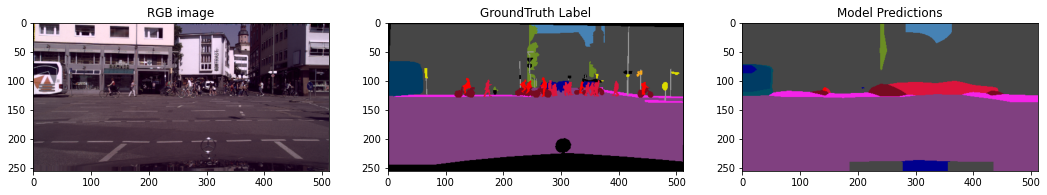

In [17]:
# load pretrained model and transfer to target Device
kd_student_model = PSPNet(num_classes=NUM_CLASSES, backbone='resnet50', pretrained=False, use_aux=False).to(gpu_device)
kd_student_model.eval();
kd_student_model.load_state_dict(torch.load('weightFiles/kd_pspnet.pt', map_location=gpu_device))

# evaluate performance on Test set
kd_student_model_metric = evaluteOnTestData(kd_student_model, None, gpu_device, testDataloader, meanIoU, 
                                    'meanIoU', 'kd_student_model_pspnet')
print(f"\nkd_student_model has {round(kd_student_model_metric,3)} IoU metric on test data")

# Visualize output predictions
visualizePredictions(kd_student_model, testSet, cpu_device, 1)

## 5. Performance comparison between Teacher and Student models


### Video output on CityScapes demoVideo (stuttgart_00) sequence

The following video is the result from applying the `Knowledge Distillation` concept to demoVideo sequence in cityscapes dataset and highlights the inference speed difference between the teacher and student models

In [ ]:
# utility function to calculate inference time on single 
# frame for given model and input image
def getModelPredInfo(model : nn.Module, input: torch.Tensor, device: torch.device):
    startTime = time.time()
    preds = model(input)
    endTime = time.time()
    
    # calculate model inference time in terms of FPS
    inferenceTime = endTime - startTime
    modelFPS = (1.0 / inferenceTime)
    return preds, modelFPS

In [ ]:
# read input images from demoVideo sequenqce
image_files = sorted(os.listdir('semSeg_256_512/demoVideo/'))
print(f'There are {len(image_files)} images in demoVideo sequence')

# SHORTCUTS FOR COLORS in (RGB convention)
black = [0,0,0] 
red = [255,0,0]

# text font and placeholder
font = cv2.FONT_HERSHEY_SIMPLEX
frame = np.ones((50, 516, 3), np.uint8) * 255

# utility function to add frame on top of image
def caption_image(image, title, pos, color = red):
    bordered_image = cv2.copyMakeBorder(image, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=black)
    image_with_frame = cv2.vconcat((frame, bordered_image))
    cv2.putText(image_with_frame, title, pos, font, 0.8, color, 2, cv2.LINE_AA)
    return image_with_frame

In [ ]:
import time
from tqdm import tqdm

torch.set_num_threads(1)

# set models to inference mode
teacher_model.eval();
teacher_model.to(cpu_device)
kd_student_model.eval();
kd_student_model.to(cpu_device)


# we'll get video of 80 images for time constraints
num_video_images = 80
result_video = []

# iterate through images
for img_path in tqdm(image_files[0:num_video_images]):
    rgb_image = cv2.cvtColor(cv2.imread(f'semSeg_256_512/demoVideo/{img_path}'), cv2.COLOR_BGR2RGB)
    torch_image = tf(rgb_image).unsqueeze(0).to(cpu_device) 

    # get model predictions, FPS
    teacher_model_preds, teacher_model_fps = getModelPredInfo(teacher_model, torch_image, cpu_device)
    kd_student_model_preds, kd_student_model_fps = getModelPredInfo(kd_student_model, torch_image, cpu_device)
    fps_improvement_percent = int(((kd_student_model_fps / teacher_model_fps) - 1) * 100)

    # get class predictions, convert to color map
    teacher_color_preds = decodeTarget(np.argmax(teacher_model_preds.detach().cpu().numpy(), axis=1)[0]).astype(np.uint8)
    kd_student_color_preds = decodeTarget(np.argmax(kd_student_model_preds.detach().cpu().numpy(), axis=1)[0]).astype(np.uint8)
    
    
    captioned_rgb_image = caption_image(rgb_image, 'RGB IMAGE', (200,35));

    captioned_teacher_preds = caption_image(teacher_color_preds, 'TEACHER MODEL', (150,35))

    captioned_student_preds = caption_image(kd_student_color_preds, 'STUDENT MODEL', (70,35))
    cv2.putText(captioned_student_preds, f'{fps_improvement_percent}% faster', (300, 35), font, 0.8, red, 2, cv2.LINE_AA);
    
    total_frame = cv2.hconcat((cv2.cvtColor(captioned_rgb_image, cv2.COLOR_RGB2BGR), 
                           cv2.cvtColor(captioned_teacher_preds, cv2.COLOR_RGB2BGR),
                           cv2.cvtColor(captioned_student_preds, cv2.COLOR_RGB2BGR)))
    
    result_video.append(total_frame)


# video writing object
out = cv2.VideoWriter('knowledge_distillation_output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 5, \
                      (total_frame.shape[1], total_frame.shape[0]))

for img in result_video:
  out.write(img)
out.release()

  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
  9%|▉         | 7/80 [00:23<04:01,  3.30s/it]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('knowledge_distillation_output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Results and conclusion

- As you can see, the student model trained with knowledge distillation is 5 times faster than the teacher model is 50% more accurate than the plain student model for the same training procedure

- The student model can match and even be better than the teacher model through combination of following factors:

  - Train longer
  - Tuning hyperparameters T (temperature) and weight alpha
  - Different loss function (eg: rmse between softmax predictions of teacher and student model predictions)
  - Matching intermediate layers of the student and teacher model
  - Data Augumentation (this can improve test set performance of both the teacher and the student model)
